# Explanaible AI - Shap - Partial Dependence Plot

Partial dependence plots (PDP) show the dependence between the target response and a set of input features of interest, marginalizing over the values of all other input features (the ‘complement’ features). Intuitively, we can interpret the partial dependence as the expected target response as a function of the input features of interest.


Documentation: 
- https://shap.readthedocs.io/en/latest/example_notebooks/overviews/An%20introduction%20to%20explainable%20AI%20with%20Shapley%20values.html

## RUN

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import sklearn

import plotly.graph_objs as go
from plotly.subplots import make_subplots
import plotly.express as px

# shap
import shap

# models
from sklearn.linear_model import LinearRegression # lr
from sklearn.linear_model import Ridge # ridge
from sklearn.linear_model import Lasso # lasso
from sklearn.tree import DecisionTreeRegressor # tree
from sklearn.ensemble import GradientBoostingRegressor #gb
from sklearn.ensemble import RandomForestRegressor #rf
from xgboost import XGBRegressor # xgb
from  sklearn.neural_network import MLPRegressor # mlp

### 0. Global params

### 1. Load data

In [2]:
# a classic housing price dataset
X, y = shap.datasets.california(n_points=1000)

In [3]:
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
14740,4.1518,22.0,5.663073,1.075472,1551.0,4.180593,32.58,-117.05
10101,5.7796,32.0,6.107226,0.927739,1296.0,3.020979,33.92,-117.97
20566,4.3487,29.0,5.930712,1.026217,1554.0,2.910112,38.65,-121.84
2670,2.4511,37.0,4.992958,1.316901,390.0,2.746479,33.20,-115.60
15709,5.0049,25.0,4.319261,1.039578,649.0,1.712401,37.79,-122.43


In [4]:
y

array([1.369  , 2.413  , 2.007  , 0.725  , 4.6    , 1.2    , 2.47   ,
       3.369  , 3.397  , 2.656  , 2.379  , 0.922  , 0.795  , 1.375  ,
       2.201  , 2.761  , 3.953  , 3.     , 1.827  , 3.864  , 1.314  ,
       0.742  , 2.31   , 3.941  , 1.761  , 1.734  , 2.021  , 1.708  ,
       0.926  , 0.57   , 4.657  , 3.726  , 4.     , 1.539  , 1.     ,
       1.587  , 1.421  , 1.396  , 3.197  , 1.313  , 1.107  , 0.849  ,
       0.704  , 2.76   , 1.58   , 0.542  , 1.232  , 1.162  , 1.592  ,
       2.155  , 2.781  , 0.66   , 2.929  , 1.712  , 2.75   , 0.962  ,
       5.00001, 1.676  , 1.829  , 2.231  , 1.733  , 1.891  , 1.177  ,
       2.468  , 0.618  , 0.934  , 0.557  , 3.905  , 2.03   , 0.889  ,
       5.00001, 1.703  , 1.55   , 0.579  , 5.00001, 1.083  , 3.506  ,
       2.032  , 2.214  , 1.553  , 2.706  , 2.     , 0.875  , 2.045  ,
       1.969  , 1.839  , 0.786  , 1.458  , 0.767  , 0.985  , 2.217  ,
       1.713  , 0.618  , 2.747  , 0.75   , 2.042  , 3.75   , 2.408  ,
       1.391  , 3.90

In [5]:
X100 = shap.utils.sample(X, 100)  # 100 instances for use as the background distribution
X100

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
12953,3.7813,15.0,5.620058,1.013500,2868.0,2.765670,38.70,-121.28
18537,4.3000,20.0,6.270677,1.137845,981.0,2.458647,36.98,-122.00
13337,3.9107,27.0,5.572816,1.000000,321.0,3.116505,34.04,-117.68
12651,1.6521,36.0,4.068477,1.121606,2460.0,2.904368,38.52,-121.44
19986,2.3152,25.0,5.412844,1.055046,1424.0,3.266055,36.21,-119.32
...,...,...,...,...,...,...,...,...
6232,3.3523,25.0,4.997245,1.112948,1187.0,3.269972,34.07,-117.94
2782,1.2049,17.0,4.337500,1.206250,775.0,2.421875,32.74,-114.66
12601,1.9837,37.0,4.786517,1.014045,902.0,2.533708,38.53,-121.48
2198,7.5000,8.0,6.564885,0.946565,1111.0,2.826972,36.85,-119.88


### 2. Train models

In [6]:
# train lr
lr = LinearRegression()
lr.fit(X, y)

LinearRegression()

In [7]:
# explore coeficients linear regression
print("Model coefficients:\n")
for i in range(X.shape[1]):
    print(X.columns[i], "=", lr.coef_[i].round(5))

Model coefficients:

MedInc = 0.42563
HouseAge = 0.01033
AveRooms = -0.1161
AveBedrms = 0.66385
Population = 3e-05
AveOccup = -0.26096
Latitude = -0.46734
Longitude = -0.46272


In [8]:
# train rf simple
param_n_trees = 3
rf_simple = RandomForestRegressor(n_estimators = param_n_trees,
                                  random_state = 42,
                                 min_samples_split = 0.2,
                                    min_samples_leaf = 0.1)
                                   #max_depth = 2)
rf_simple.fit(X, y)

RandomForestRegressor(min_samples_leaf=0.1, min_samples_split=0.2,
                      n_estimators=3, random_state=42)

### 3. Partial Dependence Plot
**Main**

To understand a feature’s importance in a model, it is necessary to understand both how changing that feature impacts the model’s output, and also the distribution of that feature’s values.


**Explication plot**

- Show the distribution of feature values as a histogram on the x-axis
- The gray horizontal line in the plot above represents the expected value of the model
- The vertical gray line represents the average value of the feature
- Note that the blue partial dependence plot line (which is the average value of the model output when we fix the median income feature to a given value) always passes through the intersection of the two gray expected value lines. We can consider this intersection point as the “center” of the partial dependence plot with respect to the data distribution

**Documentation**

- https://shap-lrjball.readthedocs.io/en/latest/generated/shap.partial_dependence_plot.html

In [9]:
# select a feature
feature = "MedInc"

#### 3.1 Partial Dependence Plot

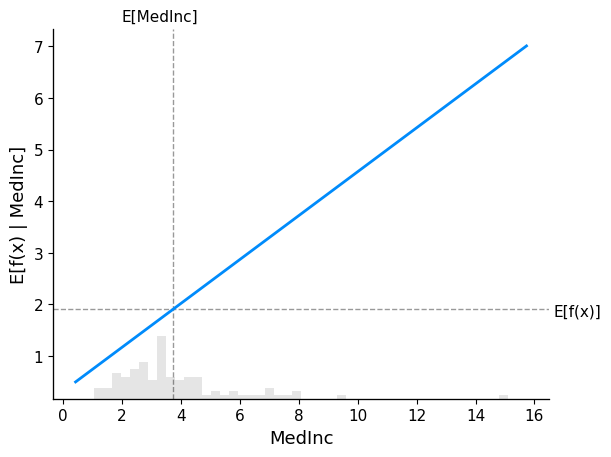

In [10]:
#partial dependence plot
shap.partial_dependence_plot(
    feature,
    lr.predict,
    X100,
    ice=False,
    model_expected_value=True,
    feature_expected_value=True,
)

#### 3.2 Patial Depence plot and the shap value (for one observation)

When we are explaining a prediction, the SHAP value for a specific feature is just the difference between the expected model output and the partial dependence plot at the feature’s value 

In [11]:
# compute the SHAP values for the linear model
explainer = shap.Explainer(lr.predict, X100)
shap_values = explainer(X)
shap_values

ExactExplainer explainer: 1001it [00:19, 38.47it/s]                                                                    


.values =
array([[ 0.17748606, -0.05673697, -0.01115696, ..., -0.32545122,
         1.46557209, -1.09436981],
       [ 0.87032679,  0.04660906, -0.06272121, ..., -0.02283925,
         0.83933912, -0.66867102],
       [ 0.26129264,  0.01560525, -0.04222865, ...,  0.00609243,
        -1.3711698 ,  1.12204024],
       ...,
       [ 1.33894557, -0.11874459, -0.31423139, ..., -0.06020864,
        -0.94589219,  1.16368468],
       [ 0.06758836, -0.1497484 ,  0.16704909, ...,  0.30915583,
        -0.72156993,  1.14054888],
       [ 0.7591522 , -0.02573316, -0.05379078, ..., -0.17721623,
         0.59632334,  0.21974387]])

.base_values =
array([1.90353381, 1.90353381, 1.90353381, 1.90353381, 1.90353381,
       1.90353381, 1.90353381, 1.90353381, 1.90353381, 1.90353381,
       1.90353381, 1.90353381, 1.90353381, 1.90353381, 1.90353381,
       1.90353381, 1.90353381, 1.90353381, 1.90353381, 1.90353381,
       1.90353381, 1.90353381, 1.90353381, 1.90353381, 1.90353381,
       1.90353381, 1.90353

In [12]:
# make a standard partial dependence plot
sample_ind = 20

In [13]:
# shap values to partial plot
shap_values_to_partial_plot = shap_values[sample_ind : sample_ind + 1, :]
shap_values_to_partial_plot

.values =
array([[-0.48900816, -0.10840999,  0.08734303, -0.06647713,  0.01402258,
        -0.04536997,  1.47024547, -1.08511549]])

.base_values =
array([1.90353381])

.data =
array([[ 2.58590000e+00,  1.70000000e+01,  4.81463415e+00,
         1.03089431e+00,  1.91100000e+03,  3.10731707e+00,
         3.25700000e+01, -1.17070000e+02]])

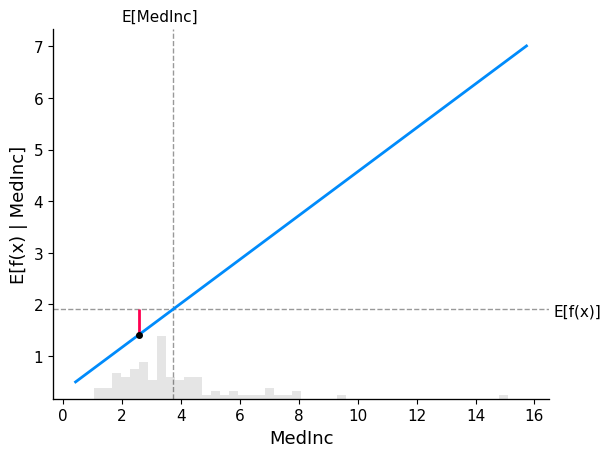

In [14]:
# the shap value is the difference between the expected model output and the partial difference plot
shap.partial_dependence_plot(
    feature,
    lr.predict,
    X100,
    ice=False,
    model_expected_value=True,
    feature_expected_value=True,
    shap_values = shap_values_to_partial_plot
)

#### 3.3 Correspondence between classic partial dependence plot and SHAP values

The close correspondence between the classic partial dependence plot and SHAP values means that if we plot the SHAP value for a specific feature across a whole dataset we will exactly trace out a mean centered version of the partial dependence plot for that feature

In [15]:
shap_values[:, feature]

.values =
array([ 1.77486063e-01,  8.70326792e-01,  2.61292636e-01, -5.46383104e-01,
        5.40591129e-01, -4.96541815e-01,  9.92269825e-01,  9.33277489e-01,
        1.10770072e+00,  7.74204186e-02, -1.70892201e-01, -4.82496021e-01,
       -1.07744182e+00, -5.32805502e-01,  3.18071695e-01,  4.49846784e-01,
        1.72405571e+00, -7.78266400e-01, -5.07821014e-01, -1.61017582e-01,
       -4.89008162e-01, -8.08401013e-01,  8.08567860e-01,  4.27245824e-01,
       -3.55317737e-01, -5.81327337e-01, -2.00005302e-01, -4.68833293e-01,
       -1.65231320e-01, -7.61198631e-01,  1.08829198e+00,  9.92354951e-01,
        3.59528070e-01,  1.33944100e-01, -6.44661101e-01, -7.42172965e-01,
        2.11791851e-01,  2.92816506e-02,  4.59237888e-02, -4.33165488e-01,
       -2.81939102e-01, -8.89584002e-02, -4.52106029e-01,  7.41856296e-02,
       -5.85684087e-02, -8.70330197e-01, -7.64561109e-01, -2.20350422e-01,
        2.49204740e-01,  7.22548010e-01,  1.17231137e+00, -3.55573115e-01,
        6.45253

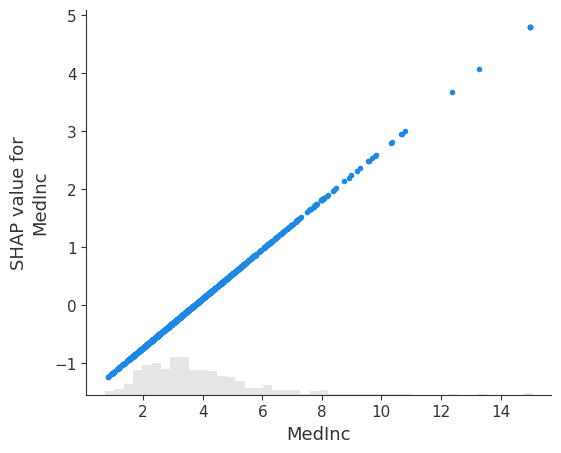

In [16]:
shap.plots.scatter(shap_values[:, feature])

#### 3.4 Plot Feature vs Predicction
Plot scatter/line where values of feature are in X-axis and target prediction are in y-axis

This idea is similar to plot PDP but the values of the rest of features are not fixed in his expected value

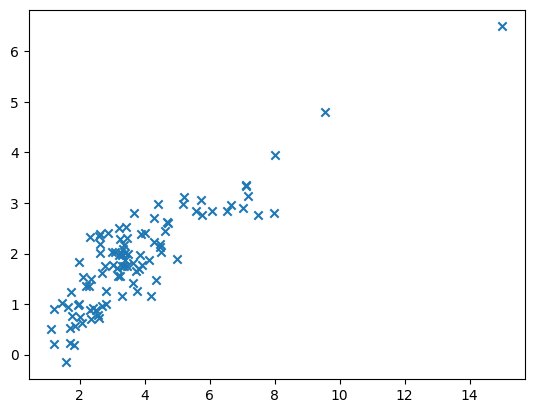

In [17]:
plt.scatter(x = X100[feature], 
            y = lr.predict(X100), 
            marker = 'x')

#### 3.5 Partial Dependence Plot - Manually - Intuition
El gráfico muestra cómo cambia la predicción del modelo en función de un conjunto específico de features, mientras se mantienen todas las demás características constantes en su valor promedio.

In [36]:
def scatter_partial_dependence_plot(feature, X, model):
    """
    Plot mine scatter plot of partial dependence plot.

    Plot how changing the predicton of a model in a function of the values of a specific feature while the rest of features not changing and
    are fixed in its mean values

    Args
        feature (string): feature to plot the partial dependence plot
        X (dataframe): dataframe of features - X
        model (model): model

    Return
        fig (figure matplotlib): figure with scatter plot of pdp of a feature
    """

    ############################## define list of features ##############################
    # list feature
    list_features = X.columns.tolist()
    print('list features: ', list_features)
    
    # calculate feature to calculate mean values
    list_features_mean = list(set(list_features) - set([feature]))
    print('list features to calculate mean: ', list_features_mean)
    
    
    ############################## generate dataframe X_pdp ##############################
    # calculate mean values - all features
    X_mean = X.mean()
    
    # get values of feature to pdp
    X_pdp = X[[feature]]
    
    
    # generate data to partial dependence plot with the mean values of all features except to feature to plot pdp
    for feature_mean in list_features_mean:
        #print('adding mean value feature: ', feature_mean)
        
        # calculate dataframe to pdp
        X_pdp[feature_mean] = X_mean[feature_mean]
    
    # sort values
    X_pdp = X_pdp[list_features]
    
    
    ############################## predict with data pdp ##############################
    # predict with mean values the rest of features
    y_pred_pdp = model.predict(X_pdp)
    
    
    ############################## plot scatter pdp ##############################
    fig = plt.figure()
    plt.scatter(x = X_pdp[feature], 
                y = y_pred_pdp, 
                marker = 'x')
    
    return fig

list features:  ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']
list features to calculate mean:  ['HouseAge', 'AveRooms', 'AveOccup', 'AveBedrms', 'Population', 'Latitude', 'Longitude']


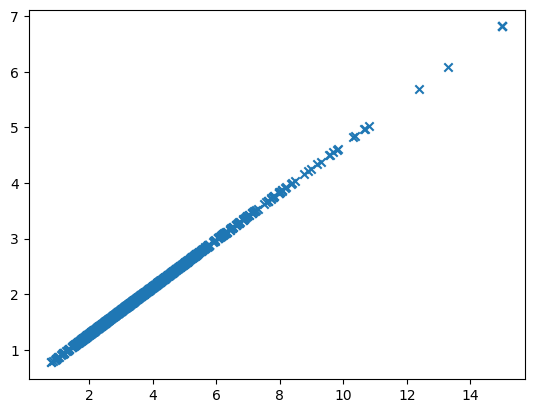

In [37]:
fig_pdp_mine_lr = scatter_partial_dependence_plot(feature = feature,
                                                  X = X,
                                                  model = lr
                                                 )

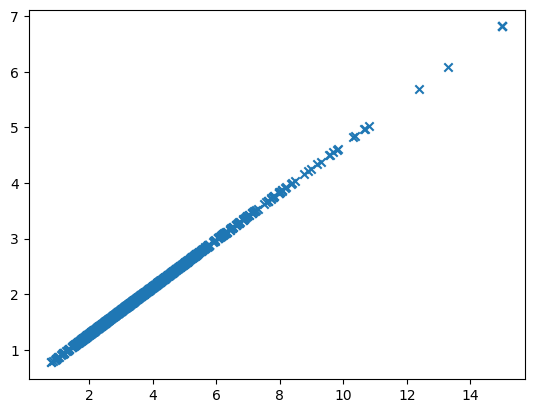

### 4. Partial Dependence plot for other model

In [25]:
# select a feature
feature = "MedInc"

In [26]:
# model
rf_simple

RandomForestRegressor(min_samples_leaf=0.1, min_samples_split=0.2,
                      n_estimators=3, random_state=42)

#### 4.1 Partial Dependence plot

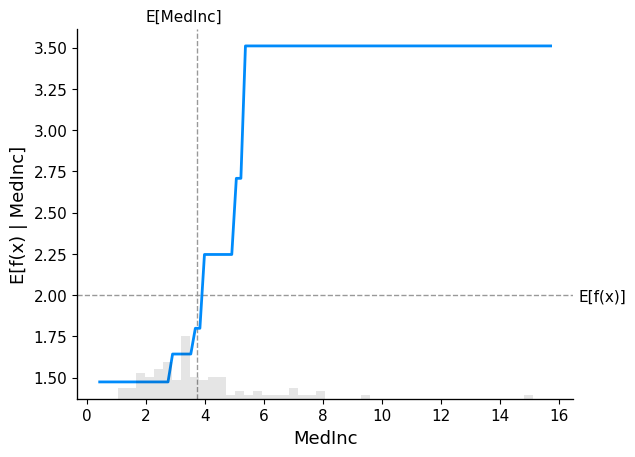

In [27]:
# partial dependence plot
shap.partial_dependence_plot(
    feature,
    rf_simple.predict,
    X100,
    ice=False,
    model_expected_value=True,
    feature_expected_value=True,
)

#### 4.2 Patial Depence plot and the shap value (for one observation)

ExactExplainer explainer: 1001it [00:16, 24.61it/s]                                                                    


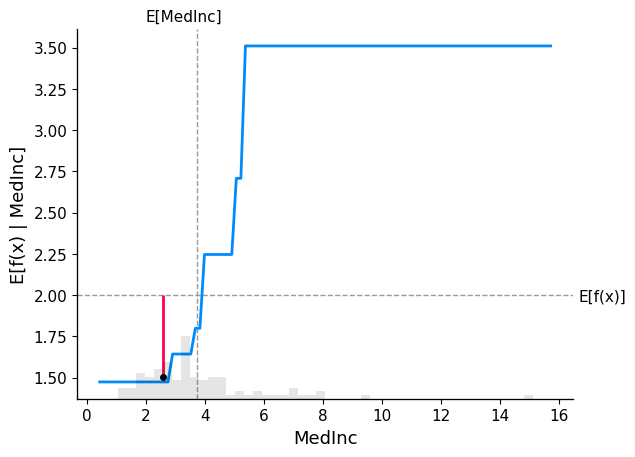

In [28]:
# compute the SHAP values for the linear model
explainer = shap.Explainer(rf_simple.predict, X100)
shap_values = explainer(X)

# make a standard partial dependence plot
sample_ind = 20

# shap values to partial plot
shap_values_to_partial_plot = shap_values[sample_ind : sample_ind + 1, :]

# the shap value is the difference between the expected model output and the partial difference plot
shap.partial_dependence_plot(
    feature,
    rf_simple.predict,
    X100,
    ice=False,
    model_expected_value=True,
    feature_expected_value=True,
    shap_values = shap_values_to_partial_plot
)

#### 4.3 Correspondence between classic partial dependence plot and SHAP values

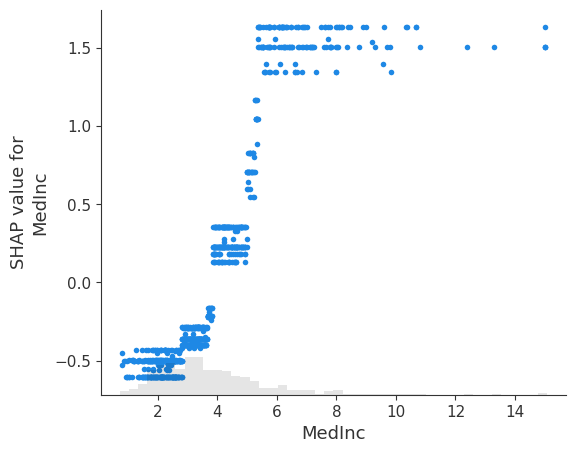

In [29]:
shap.plots.scatter(shap_values[:, feature])

#### 4.4 Plot Feature vs Predicction

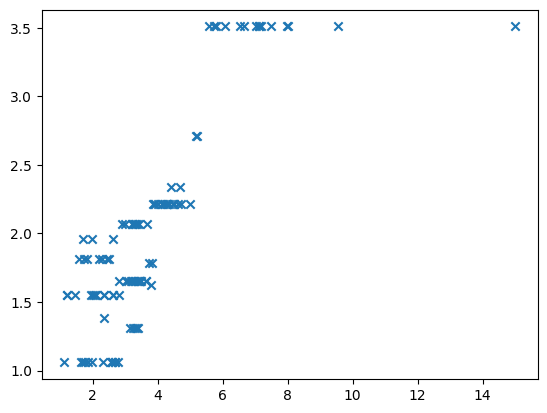

In [30]:
plt.scatter(x = X100[feature], 
            y = rf_simple.predict(X100), 
            marker = 'x')

#### 4.5 Partial Dependence Plot - Manually - Intuition

list features:  ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']
list features to calculate mean:  ['HouseAge', 'AveRooms', 'AveOccup', 'AveBedrms', 'Population', 'Latitude', 'Longitude']


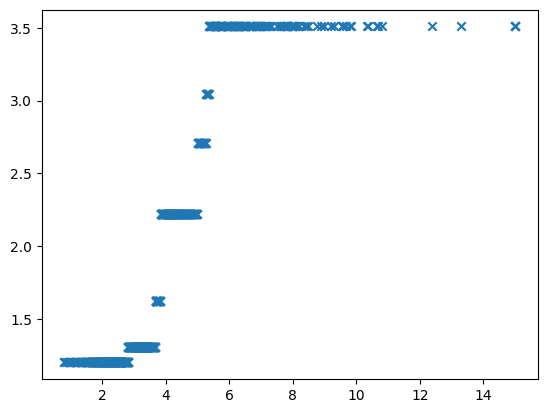

In [39]:
fig_pdp_mine_rf_simple = scatter_partial_dependence_plot(feature = feature,
                                                  X = X,
                                                  model = rf_simple
                                                 )